# This notebook is a continuation of the first Co-registration_eeg_emg. The goals of this notebook are:
- preprocessing eeg without PREP since it contains interpolation which will lead to unreliable connectivity in eeg-eeg
- preprocessing all data and distinguish connectivity before and after TMS
- breaking down the coherence calculation (variables are: frequency estimation methods, eeg-emg, new coherence metric)
- the gain of introducting eeg-emg linking with the application of graph theory

## We begin first by the coherence calculation based on data that are interpolated

In [1]:
# import epochs data
# the unit of time is ms

subjectNumber ='1'
sessionOrder = '1'
import mne
import pandas as pd
import os
epochs_ready4process_dirName = r'D:\Data\RuiJinFirstStroke11Jan\epochs_ready4process'
epochs_ready4process_fName = os.path.join(epochs_ready4process_dirName,'subj'+subjectNumber+'_healthy_session'+sessionOrder+'_epo.fif')
epochs2process = mne.read_epochs(epochs_ready4process_fName)

## pandas approach
# df = epochs2process.to_data_frame()
# epoch_idx=1
# data = df.xs(('1',epoch_idx),level = [0,1])
####

## mne approach
epochs_condt1 = epochs2process['1']
epochs_condt2 = epochs2process['2']


Reading D:\Data\RuiJinFirstStroke11Jan\epochs_ready4process\subj1_healthy_session1_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
45 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


## Measuring PSD and power spectrum with different methods
Measuring the power spectrum of a time signal illustrates which frequencies contain the signal's power. The measure is the distribution of power values as a function of frequency where "power" is considered to be the average of the signal's energy. In the frequency domain, this is the square of the FFT's magnitude.

 
A Power Spectral Density (PSD) is the measure of signal's power content versus frequency. A PSD is typically used to characterize broadband random signals. It can be looked upon as a frequency-domain plot of power per unit Hz vs. frequency.
Therefore, while the power spectrum calculates the area under the signal plot using the discrete Fourier Transform, the power spectrum density assigns units of power to each unit of frequency and thus, enhances periodicities. 

### Note: when the freq resolution is 0.1, such as the example below, the PSD= $\frac{PowerSpectrum}{0.1}$

Computing cross-spectral density from epochs...
    Computing CSD matrix for epoch 1
[done]
0 0.0 7.989444181522161e-36 4.1438611773068315e-37 (0.00015013477926610367+0j)
1 0.2 5.33212020179147e-35 3.183751570391698e-36 (0.00019970566270908493+0j)
2 0.4 1.2208884736443393e-34 3.502203654224537e-36 (0.0003664179889654354+0j)
3 0.6000000000000001 8.927285160244255e-35 5.707664833302908e-36 (0.0017643401591349252+0j)
4 0.8 1.7798792088062826e-34 5.829417889934943e-36 (0.00835851378470337+0j)
5 1.0 0.025000000000000005 2.7817651346724747e-35 (0.0013050879105491698+0j)
6 1.2000000000000002 3.1623886812806454e-34 4.074159658175451e-36 (0.00017102250897813414+0j)
7 1.4000000000000001 1.1522089925513335e-34 1.665093537388601e-35 (5.972910849253719e-05+0j)
8 1.6 7.970530659402933e-35 4.06026717448908e-35 (2.814890678429513e-05+0j)
9 1.8 2.1378392137443127e-34 1.4995924885257928e-34 (1.5482838731747973e-05+0j)
10 2.0 1.9278427811338248e-35 0.005 (9.380793044476322e-06+0j)
11 2.2 5.49233323218266

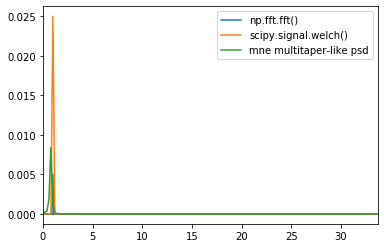

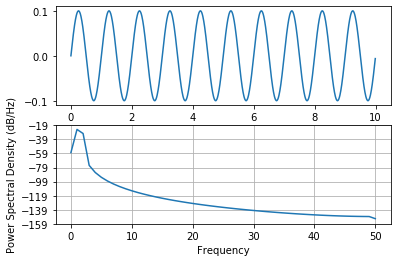

In [295]:
## Let us deal with the scaling problem in mne, scipy, matplotlib and numpy
# First step is create a reference sinusoidal signal 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import scipy.signal
from mne.time_frequency import csd_fourier, csd_multitaper, csd_morlet,csd_array_fourier,csd_array_multitaper

def abs2(x):
    return x.real**2 + x.imag**2

# numpy
dt = 0.01
t = np.arange(0, 10, dt)
s = 0.1 * np.sin(2 * np.pi * t)
ffts = np.fft.fft(s)
scale=2.0/(len(s)*len(s))
power=scale*abs2(ffts)
freq=np.fft.fftfreq(len(s),dt)

# scipy signal
freq2,power2=scipy.signal.welch(s, fs=1/dt,window='boxcar',
                                nperseg=len(s),scaling='density', axis=-1, average='mean')

# mne
psd_fft_mne = csd_array_fourier(np.array([[s,s]]),fmax=50,n_fft=1000,sfreq=100)
freqs3 = csd_fft.frequencies
# Value comparison
psd_fftValue = []
for i in range(len(freq2)-2):
    print (i, freq2[i], power2[i], power[i], psd_fft_mne[i].get_data(freq2[i])[0][0])
    psd_fftValue.append(np.real(psd_fft_mne[i].get_data(freq2[i])[0][0]))
print (np.sum(power2))
print(np.sum(psd_fftValue))

# figure
plt.figure()
plt.plot(freq[0:int(len(s)/2+1)],power[0:int(len(s)/2+1)],label='np.fft.fft()')
plt.plot(freq2,power2,label='scipy.signal.welch()')
plt.plot(freq2[np.arange(249)],np.array(psd_fftValue),label='mne multitaper-like psd')
plt.legend()
plt.xlim(0,np.max(freqs[0:int(len(s)/2+1)])/5)

plt.show()

plt.subplot(211)
plt.plot(t, s)
plt.subplot(212)
plt.psd(s, 100, 1 / dt) # scaling the x-axis, the peak should be 1Hz; Note 10*log10(0.005)=-23 
plt.show()

## Conclusion
For a real to complex transform, the correct scaling of np.multiply(u_fft, np.conj(u_fft)) is 2./(u.size*u.size). Indeed, the scaling of u_fft is 1./u.size. Furthermore, real to complex transforms only report half of the frequencies, because the magnitude of the bin N-k would be the complex conjugate of that of the bin k. The energy of that bin is therefore equal to that of bin k and it is to be summed to that of bin k. Hence the factor 2. For the tested sine wave signal of amplitude 1, the energy is reported as 0.5: it is indeed, the average of a squared sine wave of amplitude 1.

### Density and spectrum
 (‘density’) where Pxx has units of V^2/Hz **here equals to FFT of the signal powered by 2 and divided by $size^2/2$** and computing the power spectrum (‘spectrum’) where Pxx has units of V^2, if x is measured in V and fs is measured in Hz
 
### Scalings are consistent
mne applies tapering techniques in psd estimation, resulting in a PSD almost as same as conventional methods. Here, the PSD equals to Power Spectrum divided by 0.1.

## Breaking down the steps of coherence calculation: Cz and emg9

## Here epoch_2chs have 1501 samples per channel, 2 channels in total.   The freq resolution $ = \frac{sfreq}{n\_fft}$
## Conclusion: by using numpy's welch method, the plot is the 10*log10(abs(complex PSD))

d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


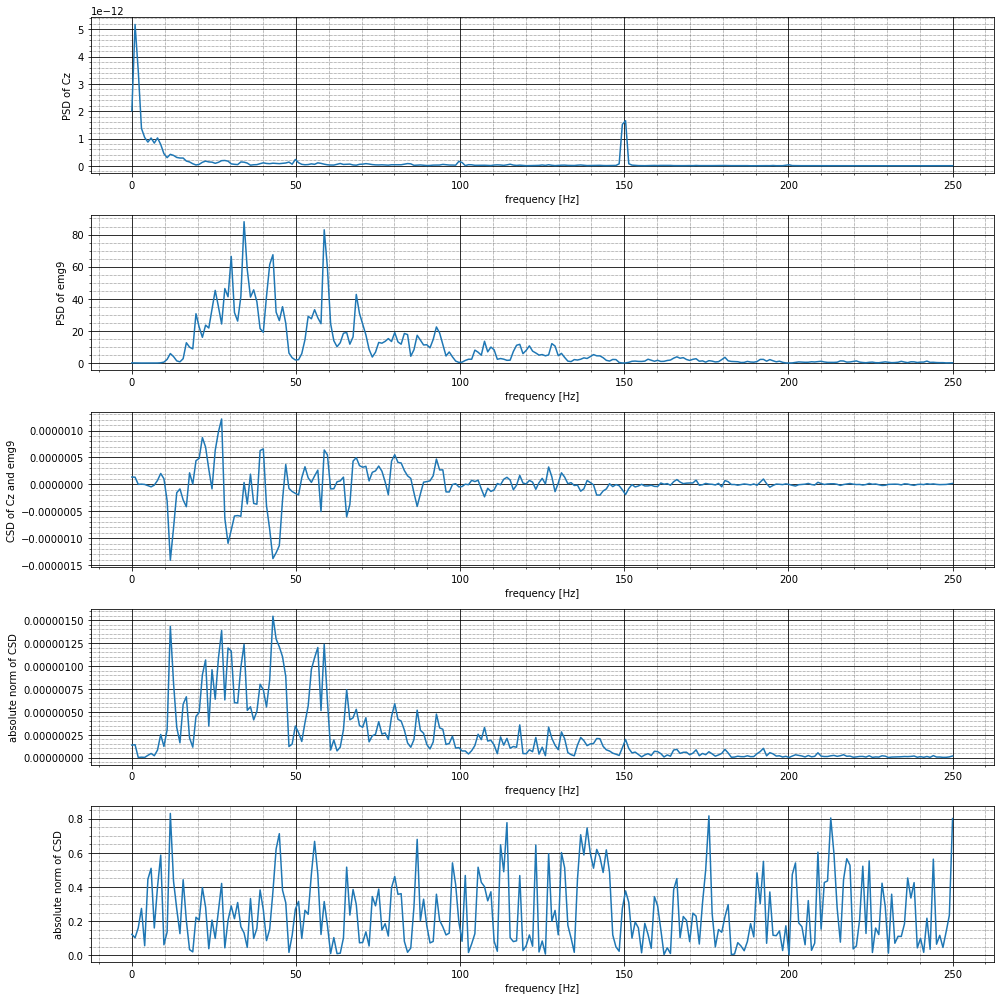

Computing cross-spectral density from epochs...
    Computing CSD matrix for epoch 1
[done]


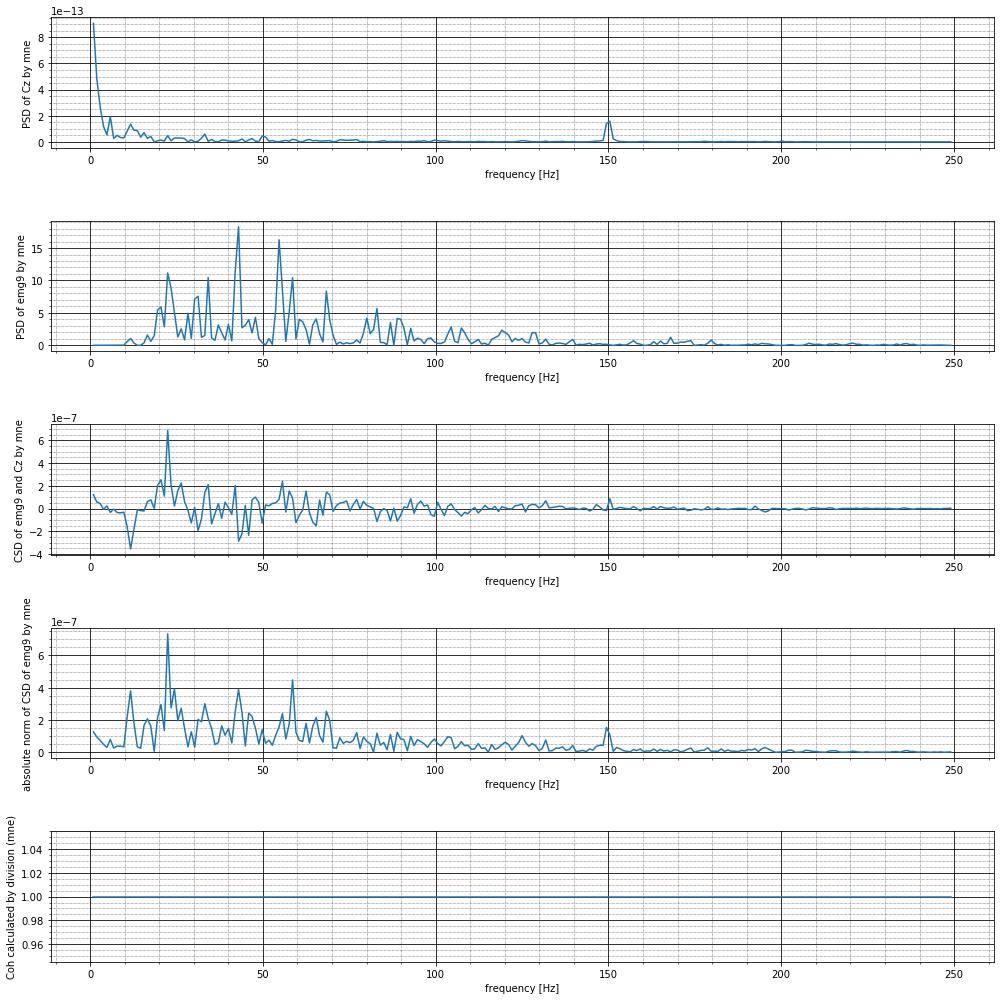

(255,)

In [372]:
from matplotlib.pyplot import csd
from mne.connectivity import spectral_connectivity
import numpy as np
from scipy import signal
from mne.time_frequency import csd_fourier,csd_array_fourier,csd_array_multitaper
from matplotlib.ticker import AutoMinorLocator
epoch_2chs = epochs_condt1.copy().pick_channels(['Cz','emg9'])[0]

# Customize axes 
def formatAxes(ax,xlabel='',ylabel=''):
    import matplotlib.pyplot as plt
    ax.grid(True)
    # ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax.minorticks_on()
    ax.grid(which='major', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return ax
    

## Coherence step by step scipy
nperseg=512
freq,psd_Cz=scipy.signal.welch(Cz, fs=500, nperseg=nperseg, axis=-1, average='mean')
freq,psd_emg9=scipy.signal.welch(emg9, fs=500, nperseg=nperseg, axis=-1, average='mean')
freq,csd_CzEmg9=scipy.signal.csd(Cz, emg9,fs=500, nperseg=nperseg, axis=-1, average='mean')
f, Cxy = signal.coherence(Cz, emg9, 500, nperseg=nperseg)
fig1 = plt.figure(figsize = (14,14))
ax1=fig1.add_subplot(511)
ax1.plot(freq,psd_Cz)
ax1=formatAxes(ax1,'frequency [Hz]','PSD of Cz')
ax2=fig1.add_subplot(512)
ax2.plot(freq,psd_emg9)
ax2=formatAxes(ax2,'frequency [Hz]','PSD of emg9')
ax3=fig1.add_subplot(513)
ax3.plot(freq,csd_CzEmg9)
ax3=formatAxes(ax3,'frequency [Hz]','CSD of Cz and emg9')
ax4=fig1.add_subplot(514)
ax4.plot(f, np.sqrt(abs2(csd_CzEmg9)))
ax4=formatAxes(ax4,'frequency [Hz]','absolute norm of CSD')
ax5=fig1.add_subplot(515)
ax5.plot(f, Cxy)
ax5=formatAxes(ax5,'frequency [Hz]','absolute norm of CSD')
plt.tight_layout()
plt.show()

## Coherence estimation by mne
psd_Cz_mne = csd_array_fourier(np.array([[Cz,emg9]]),fmax=250,n_fft=nperseg,sfreq=500)
freqs = psd_Cz_mne.frequencies
psd_Cz_mne_value = []
psd_emg9_mne_value = []
csd_CzEmg9_mne_value = []
absCsd_CzEmg9_mne_value = []
coh_CzEmg9_mne_division_value = []
for i in range(len(freqs)):
    psd_Cz_mne_value.append(psd_Cz_mne[i].get_data()[0][0])
    psd_emg9_mne_value.append(psd_Cz_mne[i].get_data()[1][1])
    csd_CzEmg9_mne_value.append(psd_Cz_mne[i].get_data()[0][1])
    absCsd_CzEmg9_mne_value.append(np.sqrt(abs2(psd_Cz_mne[i].get_data()[0][1])))
    coh_CzEmg9_mne_division_value.append(absCsd_CzEmg9_mne_value[i]/np.sqrt(psd_emg9_mne_value[i])/
                                         np.sqrt(psd_Cz_mne_value[i]))
                                                                 
fig2 = plt.figure(figsize = (14,14))
ax1 = fig2.add_subplot(511)
ax1.plot(freqs,psd_Cz_mne_value)
ax1=formatAxes(ax1,'frequency [Hz]','PSD of Cz by mne')
ax2 = fig2.add_subplot(512)
ax2.plot(freqs,psd_emg9_mne_value)
ax2=formatAxes(ax2,'frequency [Hz]','PSD of emg9 by mne')
ax3 = fig2.add_subplot(513)
ax3.plot(freqs,csd_CzEmg9_mne_value)
ax3=formatAxes(ax3,'frequency [Hz]','CSD of emg9 and Cz by mne')
ax4 = fig2.add_subplot(514)
ax4.plot(freqs,absCsd_CzEmg9_mne_value)
ax4=formatAxes(ax4,'frequency [Hz]','absolute norm of CSD of emg9 by mne')
ax5 = fig2.add_subplot(515)
ax5.plot(freqs,coh_CzEmg9_mne_division_value)
ax5=formatAxes(ax5,'frequency [Hz]','Coh calculated by division (mne)')
plt.tight_layout()
plt.show()
# con, freqs, times,n_epochs,n_tapers = spectral_connectivity(
#      np.array([[Cz,emg9]]), method='coh', mode='multitaper', sfreq=500, mt_adaptive=False, n_jobs=1)


## Conclusion:
### Magnitude-squared coherence (MSC) 
The MSC is defined as $ C_{xy}(f)={\frac {|C_{xy}(f)|^{2}}{P_{xx}(f)P_{yy}(f)}}$. In view of random process (wide-sense), the $C_{xy}$ is used to measure the cross-correlation in the sense of  probability. For a finite signal, we usually estimate (simplified Welch's method) the $C_{xy}(f)$ as $C_{x}(f)C_{y}^{*}(f)$, which results to $C_{xy}(f)=1$ for any single chunk (window) of data. That is what is expected from mne which uses one window (n_fft = the number of the samples).
### Interpretation of coherence with welch's averaging techniques (Scipy's method)
The definition of MSC in trending scientific papers are $ C_{xy}(f)={\frac {|Expectation[C_{xy}(f)]|^{2}}{E[P_{xx}(f)]E[P_{yy}(f)]}}$. The expectation is the average over various short windows. To make it more clear, consider two signal $X(t),Y(t)$

| Windowed signal | &nbsp; FT  &nbsp; &nbsp; &nbsp; |    estimated PSD/CSD  &nbsp; &nbsp; &nbsp;  &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;      |       E(CSD) &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;  &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;  &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;   &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp;   &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;    &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;        |
|-----------------|:----------------------------:|:-----------------------------:|----------------------------------------------|
|     $X_1(t)$    | $X_1(f)$ | $PSD(X_1)=X_1(f)X_1^*(f)$     | $E(CSD)=|\bar{CSD(X_i,Y_i)}|_2$              |
|                 |          | $CSD(X_1,Y_1)=X_1(f)Y_1^*(f)$ |$E(CSD)=<(X_1(f),X_2(f)),(Y_1(f),Y_2(f))>^2$  |
|     $X_2(t)$    | $X_2(f)$ | $PSD(X_2)=X_2(f)X_1^*(f)$     |                                              |
|                 |          | $CSD(X_2,Y_2)=X_2(f)Y_2^*(f)$ |                                              | 
|     $Y_1(t)$    | $Y_1(f)$ |  $PSD(Y_1)=Y_1(f)Y_1^*(f)$    |                                              |
|     $Y_2(t)$    | $Y_2(f)$ |  $PSD(Y_2)=Y_2(f)Y_1^*(f)$    |                                              |                    

The Cauchy-Schwarz Inequality $⟨x,y⟩|^2\leq⟨x,x⟩⋅⟨y,y⟩$ ensures that the coherence via averaged CSD ranges between 0 and 1. Coh equals to 1 when$ (X_1(f),X_2(f))$ and $(Y_1(f),Y_2(f)$ are linear dependent. In other words, the frequency domain magnitude change coherently in X and in Y. The Coh acturally measures the cosine of the angle between the vectors $ (X_1(f),X_2(f))$ and $(Y_1(f),Y_2(f)$.

### Future direction
- Various norms can be applied to calculate the expectation.
- The biological base asserts that the frequency band of EEG and EMG activation should be different. Thus, frequency-lag cross spectral density is envisaged to measure EEG-EMG coherence. Please note that in conventional Coh calculation, the f is identical for both X and Y.

## embedded methods in mne

Computing cross-spectral density from epochs...
    Computing CSD matrix for epoch 1
[done]


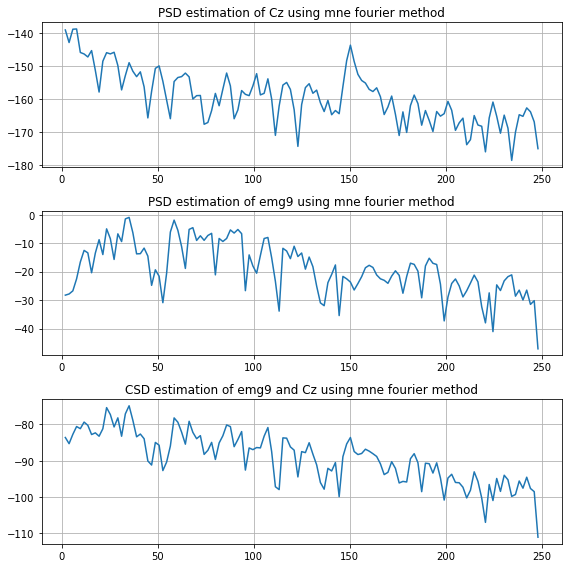

In [134]:
csd_fft = csd_fourier(epoch_2chs,fmax=250,picks='all',n_fft=256)
freqs = csd_fft.frequencies
psd_Cz = []
psd_emg9 = []
csd_Cz_emg9 = []
for freq in freqs:
    psd_Cz.append(10*np.log10(csd_fft.get_data(freq)[0][0]))
    psd_emg9.append(10*np.log10(csd_fft.get_data(freq)[1][1]))
    csd_Cz_emg9.append(10*np.log10(np.abs(csd_fft.get_data(freq)[0][1])))

# Plotting
fig=plt.figure(figsize = (8,8))

## Welch's method to calculate PSD and CSD
ax=fig.add_subplot(311)
ax.plot(freqs,psd_Cz)
ax.grid(True)
ax.set_title('PSD estimation of Cz using mne fourier method')
ax1=fig.add_subplot(312)
ax1.plot(freqs,psd_emg9)
ax1.grid(True)
ax1.set_title('PSD estimation of emg9 using mne fourier method')
ax2=fig.add_subplot(313)
ax2.plot(freqs,csd_Cz_emg9)
ax2.grid(True)
ax2.set_title('CSD estimation of emg9 and Cz using mne fourier method')
plt.tight_layout()


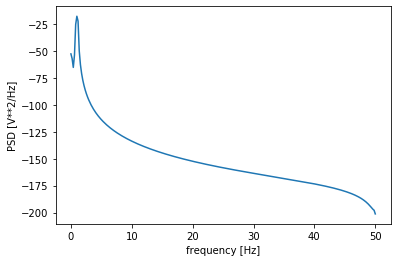

In [171]:
from scipy import signal
f, Pxx_den = signal.welch(s, 100, nperseg=512)
plt.plot(f, 10*np.log10(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

## Welch's method to calculate PSD and CSD via matplotlib
Cz = epoch_2chs.get_data()[0][0]
emg9 = epoch_2chs.get_data()[0][1]
ax=fig.add_subplot(311)
ax.add_line(csd(Cz,emg9,Fs=500,return_line=True)[2][0])
ax.set_title('CSD estimation of Cz and emg9 using Welch method')
ax2=fig.add_subplot(312)
ax2.add_line(csd(Cz,Cz,Fs=500,return_line=True)[2][0])
ax2.set_title('PSD estimation of Cz using Welch method')
ax3=fig.add_subplot(313)
ax3.add_line(csd(emg9,emg9,Fs=500,return_line=True)[2][0])
ax3.set_title('PSD estimation of emg9 using Welch method')
plt.tight_layout()